In [1]:
import normflows as nf
from normflows import flows
## Standard libraries
import os
import math
import time
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim

import dgl #NOTE: for dgl.batch and dgl.unbatch
from dgl import save_graphs, load_graphs
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import save_info, load_info, Subset

from tqdm import tqdm

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/tmp/ipykernel_1514798/3111489797.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Using device cuda:0


In [2]:
#custom imports
from utils import load_graph_dataset, train, evaluate, GraphDataset, get_graph_dataset_info
from models import GIN, HeteroGIN

In [3]:
from numpy.random import default_rng
rng = default_rng()


In [63]:
'''                                              '''
'''     SETTING UP LATENT SPACE REPRESENTATION   '''
'''                                              '''

# Data and MC both have the same prefix
prefix = "/hpc/group/vossenlab/mfm45/.dgl/"

# MC inside Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
MCdataset = "Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

# Data inside data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
DATAdataset = "data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

max_events = 1e5
split = 0.1
nlayers = 2
nmlp = 3
hdim = 64
nclasses, nfeatures, nfeatures_edge = get_graph_dataset_info(dataset=dataset, prefix=prefix)
dropout = 0.8
learn_eps = False
batch = 256
indices = None
nworkers = 0
npooling = "max"
gpooling = "max"
torch.manual_seed(0)

#select model
extractor = GIN(nlayers, nmlp, nfeatures,
            hdim, nclasses, dropout, learn_eps, npooling, gpooling).to(device)
extractor.load_state_dict(torch.load("logs/model_weights",map_location=device))
#select training data

<All keys matched successfully>

In [64]:
split = 0.8
max_events = 140000
test_range = range(int(split*max_events),max_events)
test_dataset = GraphDataset(prefix+dataset)
test_dataset.load()
# test_dataset = Subset(test_dataset,range(int(min(len(test_dataset),max_events)*split)))
test_dataset = Subset(test_dataset,test_range)
test_bg = dgl.batch(test_dataset.dataset.graphs[test_dataset.indices.start:test_dataset.indices.stop])
test_bg = test_bg.to(device)
#grab latent space representation of graphs
test_latent_repr = extractor.get_latent_repr(test_bg).detach().cpu()

In [65]:
train_range = range(0, int(split*max_events))
train_dataset = GraphDataset(prefix+dataset)
train_dataset.load()
# train_dataset = Subset(train_dataset, range(int(min(len(test_dataset),max_events)*split),int(min(len(test_dataset),max_events))))
train_dataset = Subset(train_dataset, train_range)
train_dgl = dgl.batch(train_dataset.dataset.graphs[train_dataset.indices.start:train_dataset.indices.stop])
train_dgl = train_dgl.to(device)
#grab latentspace
train_latent_repr = extractor.get_latent_repr(train_dgl).detach().cpu()

In [66]:
#new dims for training
train_num_events = train_latent_repr.size()[0]
train_latent_size = train_latent_repr.size()[1]

#calculate new dimensions for square version of latent space
test_num_events = test_latent_repr.size()[0]
test_latent_size = test_latent_repr.size()[1]

assert(train_latent_size == test_latent_size)

In [67]:
class Latent_data:
    def __init__(self, in_tensor):
        self.data = in_tensor
        self.num_events = in_tensor.size()[0]
        self.latent_size = in_tensor.size()[1]
    def set_batch_size(self,batch_size):
        self.batch_size = batch_size
    def sample(self,iteration = 0, random = False):
        if(random):
            return self.sample_random()
        else:
            return self.sample_fixed(iteration)
    def sample_fixed(self,iteration):
        #0 index iterations - the "first" iteration is with iteration = 0
        # Calculate the first index we want to take from training data (rest of data is directly after)
        begin = iteration * self.batch_size
        # initialize
        samples = torch.zeros(self.batch_size, self.latent_size)
        #loop over consecutive tensors, save to return tensor
        for i in range(self.batch_size):
            samples[i] = self.data[begin + i]
        return samples
    def sample_random(self):
        indices = rng.integers(low=0, high=self.num_events, size=self.batch_size)
        samples = torch.zeros(self.batch_size,self.latent_size)
        for index in range(len(indices)):
            samples[index] = self.data[indices[index]]
        return samples

In [68]:
'''
Trying different model from image.ipynb
'''
def get_masked_affine(num_layers = 32):
    #mask
    b = torch.ones(71)
    for i in range(b.size()[0]):
        if i % 2 == 0:
            b[i] = 0
    masked_affine_flows = []
    for i in range(num_layers):
        s = nf.nets.MLP([71, 142, 142, 71])
        t = nf.nets.MLP([71, 142, 142, 71])
        if i % 2 == 0:
            masked_affine_flows += [nf.flows.MaskedAffineFlow(b, t, s)]
        else:
            masked_affine_flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    return masked_affine_flows
masked_affine_flows_train = get_masked_affine()
distribution = nf.distributions.DiagGaussian(train_latent_size, trainable = False)
masked_affine_model = nf.NormalizingFlow(q0=distribution, flows=masked_affine_flows_train)
model = masked_affine_model.to(device)

In [69]:
#set training info
max_iter = int(np.floor((0.8 * 139000) / 500))
num_samples = 500
show_iter = 500

In [70]:
training_data = Latent_data(train_latent_repr)
training_data.set_batch_size(num_samples)

In [71]:
# train the model
model.train()
loss_hist = np.array([])
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
with tqdm(total=max_iter, position=0, leave=True) as pbar:
    for it in tqdm(range(max_iter), position = 0, leave=True):
        optimizer.zero_grad()
        #randomly sample the latent space
        samples = training_data.sample(iteration = it)
        samples = samples.to(device)
        loss = model.forward_kld(samples)
        # Do backprop and optimizer step
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        # Log loss
        if~(torch.isnan(loss)):
            loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

# Plot loss

  0%|          | 0/222 [00:16<?, ?it/s]


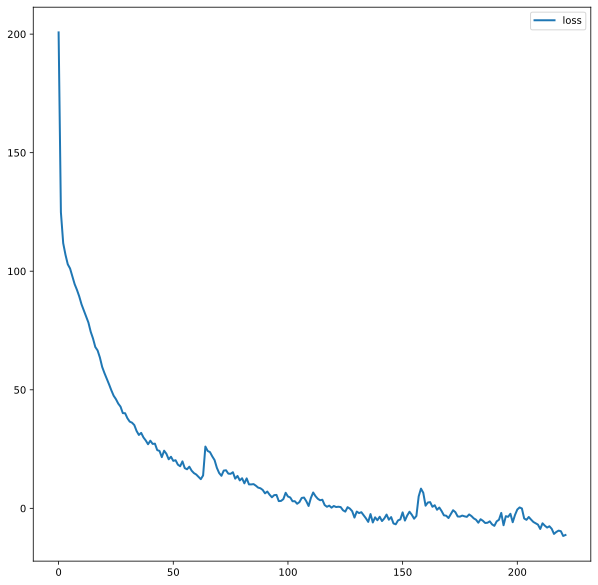

In [72]:
fig = plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()
fig.savefig("loss_masked_affine.jpeg")

In [73]:
loss_hist.min()

-11.650217056274414

In [74]:
testing_data = Latent_data(test_latent_repr)
testing_data.set_batch_size(num_samples)
max_iter_test = int(np.floor((testing_data.num_events / num_samples)))

In [75]:
#testing

torch.manual_seed(42)
model.eval()
num_samples = 500
test_loss = 0
new_loss = 0
counted_batches = 0
with torch.no_grad():
    for it in tqdm(range(max_iter_test), position = 0, leave=True):
        test_samples = testing_data.sample(iteration = it)
        test_samples = test_samples.to(device)
        new_loss = model.forward_kld(test_samples)
        if(not math.isnan(new_loss)):
#             print(f"new_loss: {new_loss}")
            test_loss += new_loss
            counted_batches += 1
    print(f"average loss: {test_loss/counted_batches}")

100%|██████████| 56/56 [00:01<00:00, 49.96it/s]

average loss: -9.335673332214355


In [76]:
#avg loss on trained gauss: -7.84237003326416

In [77]:
transformed_latent = torch.zeros_like(test_latent_repr)

In [78]:
output_batches = torch.empty(max_iter_test,num_samples,testing_data.latent_size)

In [79]:
# Closure Test - run inverse() then forward()

'''
Inverse run
    -input: latent_repr
    -output: gaussian version
'''
torch.manual_seed(42)
model.eval()
num_samples = 500
counted_batches = 0
with torch.no_grad():
    for it in tqdm(range(max_iter_test), position = 0, leave=True):
        test_samples = testing_data.sample(iteration = it)
        test_samples = test_samples.to(device)
        output_batches[it] = model.inverse(test_samples)
        #for i in range(num_samples):
        #    transformed_latent[it*num_samples + i] = output_batch[i]
output_batches = output_batches.to(device)

100%|██████████| 56/56 [00:00<00:00, 58.01it/s]


In [80]:
'''
Forward run
    -input: gauss version
    -output: latent space
'''
final_output = torch.empty(output_batches.size()[1],output_batches.size()[2])
transformed_latent = torch.zeros_like(test_latent_repr)
model.eval()
counted_batches = 0
with torch.no_grad():
    for it in tqdm(range(max_iter_test), position = 0, leave=True):
        final_output = model.forward(output_batches[it])
        for i in range(num_samples):
            transformed_latent[it*num_samples + i] = final_output[i]

100%|██████████| 56/56 [00:01<00:00, 49.66it/s]


In [81]:
diff = transformed_latent - test_latent_repr
print(f"max difference: {diff.max()}\naverage difference: {diff.sum() / np.prod(transformed_latent.size())}")

max difference: 8.58306884765625e-06
average difference: 1.2198321996947925e-07


In [82]:
print(f"average error: {100*(diff.sum() / np.prod(transformed_latent.size()))/(transformed_latent.sum() / np.prod(transformed_latent.size()))}%")

average error: 1.0209369975200389e-05%


Max diff: tensor(1.2398e-05)

average diff: tensor(1.2707e-07) | tensor(1.3718e-07)